In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = 'figures/multiyear_figs/'
# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")

In [2]:
# Years to load
start = 2007
end = 2014
# Sites to load
sites = ['Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm']

# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2014_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_

## Hours per day of C uptake and evaporative fraction

In [3]:
for site in sites:
    # Add a column with 0.5 for each uptake period (to sum)
    hourly[site]['hrs_C_uptake'] = 0
    test = hourly[site].FC_F < 0
    hourly[site].loc[test, 'hrs_C_uptake'] = 0.5
    
    hourly[site]['evap_frac'] = np.nan
    bowen =  hourly[site].H_F / hourly[site].LE_F
    hourly[site].evap_frac = 1/(1+bowen)
    day_test = hourly[site].SW_IN_F < 50
    hourly[site].loc[day_test, 'evap_frac'] = np.nan
    

# Beware here that the bowen ration looks a little crazy, especially at night.
# Perhaps we need to do a better job of removing/correcting H and LE fluxes

In [4]:
#Annual file for marcy
yearly = { x : 
         tr.resample_30min_aflx( hourly[x], freq='A', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F', 'evap_frac' ], 
                                sum_cols=[ 'P_F', 'hrs_C_uptake' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }
yearly_sums = pd.DataFrame()
for i in yearly.keys():
    new = yearly[i]
    new['site'] = i
    yearly_sums = yearly_sums.append(new)
    
yearly_sums.to_csv('processed_data/yearly_sums.csv', na_rep=-9999, date_format='%Y')


In [7]:
# Resample all hourly dataframes in Hourly to daily and add to daily dict
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F',
                                          'evap_frac' ], 
                                sum_cols=[ 'P_F', 'hrs_C_uptake' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }

# Get time of min NEE, max GPP, and daily ET and PET
for i, site in enumerate(sites):
    h = hourly[site]
    # Get the time of day for peak GPP each day
    gpp_grp = h.GPP.groupby(h.index.date)
    peakGPP_t = gpp_grp.apply(lambda x: x.index[x==x.max()].time)
    # Get the time of day for peak NEE each day
    nee_grp = h.FC_F.groupby(h.index.date)
    peakNEE_t = nee_grp.apply(lambda x: x.index[x==x.min()].time)
    def get_frac( arr ):
        # Sometimes these are empty
        if len(arr)==0:
            return np.nan
        else:
            return (arr[0].hour*3600 + arr[0].minute*60)/(3600*24)
    # Calculate daily ET and PET (see NMEG_utils/py_modules/transform_nmeg for documentation)
    daily_et_pet = tr.get_daytime_et_pet( h, freq='1D')
    
    daily[site][ 'peakGPP_dayfrac'] = peakGPP_t.apply( get_frac )
    daily[site][ 'peakNEE_dayfrac'] = peakNEE_t.apply( get_frac )
    daily[site][ 'ET_F_mm_daytime'] = daily_et_pet.ET_mm_daytime
    daily[site][ 'PET_F_mm_daytime'] = daily_et_pet.PET_mm_daytime
# Convert this to a pandas panel
d = pd.Panel(daily)

In [8]:
d.Ses.columns

Index(['GPP_g_int', 'RECO_g_int', 'FC_F_g_int', 'ET_mm_fullday_0', 'P_F',
       'hrs_C_uptake', 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F', 'evap_frac',
       'TA_F_min', 'VPD_F_min', 'TA_F_max', 'VPD_F_max', 'peakGPP_dayfrac',
       'peakNEE_dayfrac', 'ET_F_mm_daytime', 'PET_F_mm_daytime'],
      dtype='object')

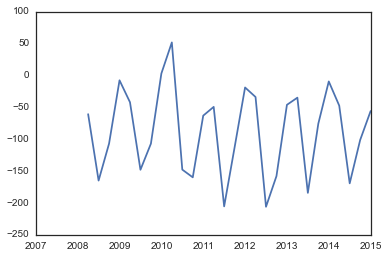

In [9]:
# Calculate the 3 month climatic water deficit (can be used in SPEI calc)
P_3m = pd.rolling_sum(d.Mpj.P_F, 90, min_periods=90)
PET_3m = pd.rolling_sum(d.Mpj.PET_F_mm_daytime, 90, min_periods=90)
spei = P_3m - PET_3m
spei.resample('3M', how='mean').plot()

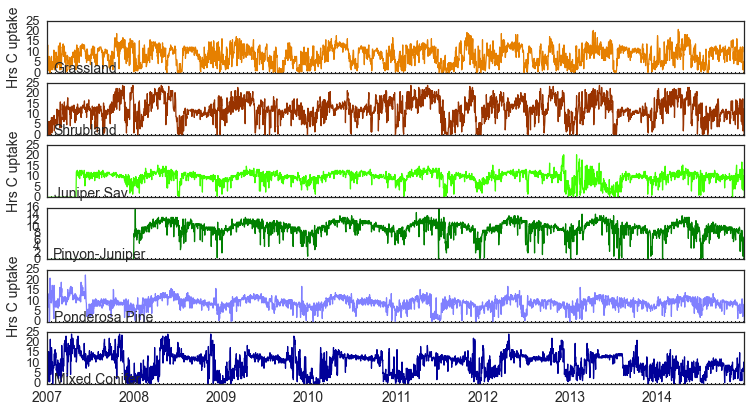

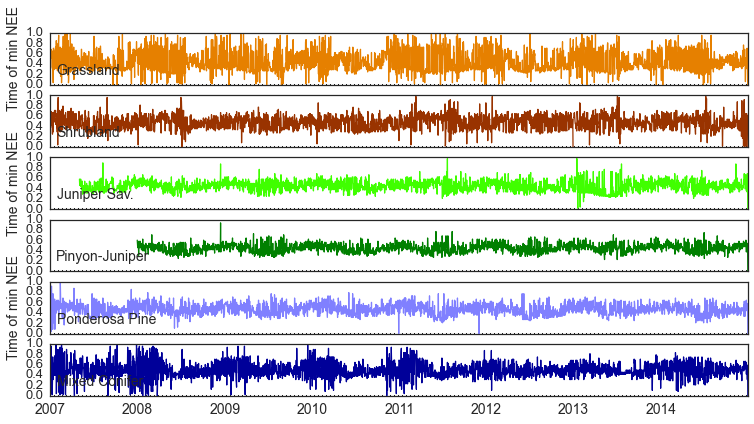

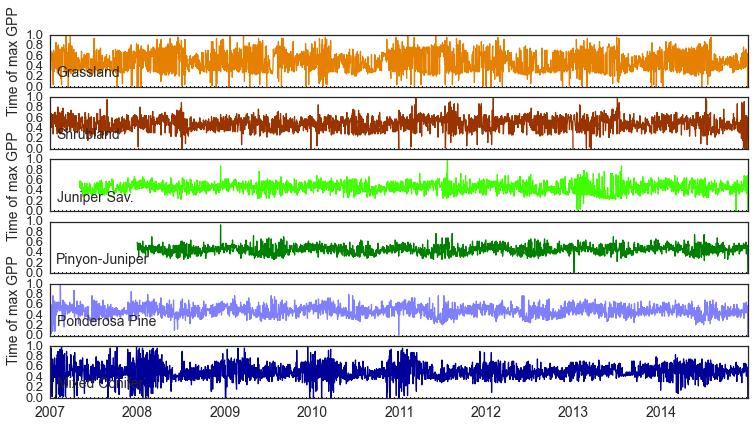

In [10]:
%matplotlib inline
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'hrs_C_uptake', .2, fig, 'Hrs C uptake')
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'peakNEE_dayfrac', .2, fig, 'Time of min NEE')
fig = plt.figure(figsize=( 12.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'peakGPP_dayfrac', .2, fig, 'Time of max GPP')

## Plot definitions

In [11]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

# Plot definition for a 6x1 plot of timeseries
def plot_tseries2( dict_in1, dict_in2, texty, fighandle, ylab,
                            xlims=[ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )],
                            ylims=None, sitelist=sites,
                            sitenames=nmegplt.names, colors=nmegplt.palette):
    
    ax = list();
    for i, site in enumerate(sitelist):
        # Pull out dataframes
        df1 = dict_in1[site]
        df2 = dict_in2[site]
            
        ax.append(fighandle.add_subplot(6, 1, i+1))
        plt.plot( xlims, [0, 0], ':k')
        plt.plot( df1.index, df1.values, color=colors[i], lw=1.25, alpha=0.4 )
        plt.plot( df2.index, df2.values, color=colors[i], lw=1.25 )
        if ylims:
            plt.ylim( ylims )
            
        plt.xlim( xlims )
        plt.text( dt.datetime( 2007, 2, 1 ), texty, sitenames[i], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        if i < 5:
            plt.setp( ax[i].get_xticklabels(), visible=False)
    
    for i in (0, 2, 4):
        ax[i].set_ylabel(ylab, fontsize=14)
    
    plt.setp( ax[5].get_xticklabels(), fontsize=14 )
    return ax

## Detect seasonal condition functions

In [12]:
# Group days meeting a particular condition according to a specified
# duration. Contiguous "true" days >= duration are marked true
def condition_duration_match( condition, obs_duration ):
    # Use shift-compare-cumsum algorithm to group contiguous periods of
    # meeting or not meeting the condition (True or False in column)
    cgroup = (condition != condition.shift()).cumsum()
    # Count the number of contiguous observations in "True" cgroups
    cgroup_counts = cgroup[condition==True].value_counts()
    # Get the egroups with given duration or greater and 
    # find in original condition array
    true_duration_cgroups = cgroup_counts.index[cgroup_counts.values >= obs_duration]
    condition_duration = np.in1d(cgroup, true_duration_cgroups)
    
    return condition_duration

# Get the start and end dates of a conditional array by year. Useful for
# determining growing seasons or suchlike
def get_condition_season( df, condition_col ):
    # Subset array to true values only using condition column
    df_true_cond = df.loc[ df[condition_col], [condition_col,] ].copy()
    # Duplicate the index into a new column, then group by year
    # and get first/last occurrence of true values in each year
    df_true_cond['season_date'] = df_true_cond.index
    startdates = df_true_cond.groupby(df_true_cond.index.year).first()
    enddates = df_true_cond.groupby(df_true_cond.index.year).last()
    # Put start and end dates in a dataframe
    new_df = pd.DataFrame( index=startdates.index )
    new_df['start_seas'] = startdates.season_date
    new_df['end_seas'] = enddates.season_date
    new_df['numdays'] = enddates.season_date - startdates.season_date
    
    return new_df
    

## Calculate growing season

In [13]:
gs = {}
GPP_threshold = [0.25, 0.25, 0.7, 1.0, 1.7, 0.5 ]
for i, site in enumerate(d.items):
    d[site]['tenday_uptake'] = condition_duration_match( d[site].GPP_g_int > GPP_threshold[i], 10 )
    gs[site] = get_condition_season( d[site], 'tenday_uptake')

gs = pd.Panel(gs)
gs.Wjs

,start_seas,end_seas,numdays
2007,2007-05-04 00:00:00,2007-11-24 00:00:00,204 days 00:00:00
2008,2008-02-22 00:00:00,2008-12-13 00:00:00,295 days 00:00:00
2009,2009-01-28 00:00:00,2009-11-16 00:00:00,292 days 00:00:00
2010,2010-02-14 00:00:00,2010-11-14 00:00:00,273 days 00:00:00
2011,2011-02-11 00:00:00,2011-11-24 00:00:00,286 days 00:00:00
2012,2012-03-12 00:00:00,2012-11-09 00:00:00,242 days 00:00:00
2013,2013-07-27 00:00:00,2013-11-21 00:00:00,117 days 00:00:00
2014,2014-02-09 00:00:00,2014-11-11 00:00:00,275 days 00:00:00


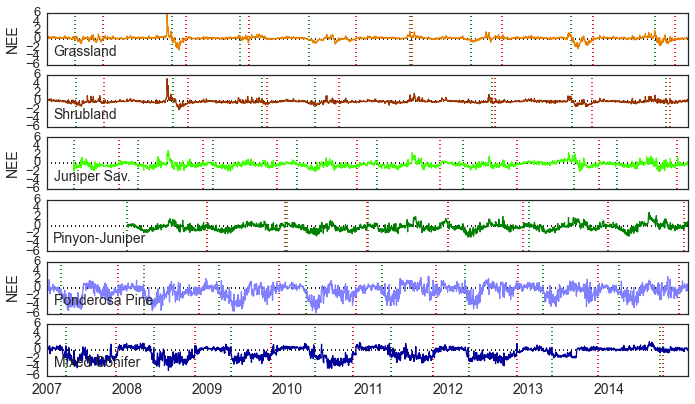

In [14]:
fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'FC_F_g_int', -4, fig, 'NEE')

# Add lines for growing season
for i, site in enumerate(nmegplt.sites):
    ax[i].vlines( list(gs[site].start_seas), [-6], [6], linestyle=':', color='Green' )
    ax[i].vlines( list(gs[site].end_seas), [-6], [6], linestyle=':', color='Red' )


## Get anomaly/climatology data

In [18]:
# Get climatologies
import math
def get_anomaly( ser, multiobs=None, norm_to_mean=False ):
    # Get summary stats for each day of the year
    allyr_mean = ser.groupby(ser.index.dayofyear).mean()
    allyr_std = ser.groupby(ser.index.dayofyear).std()
    allyr_stderr = allyr_std / math.sqrt( len(np.unique(ser.index.year))-1 )

    # Calculate the anomaly of the original series
    # (subtract multiyear mean)
    anom = ser.copy()
    if multiobs:
            allyr_mean = pd.rolling_mean( allyr_mean, multiobs, center='True')
            ser = pd.rolling_mean( ser, multiobs, center=True)
    for i in np.unique(ser.index.year):
        # Get appropriate number of allyr_mean values
        allyr_vals = allyr_mean[0:len(ser[ ser.index.year==i ])].values
        anom[ anom.index.year==i ] = ser[ ser.index.year==i ] - allyr_vals
        # If requested, normalize anomaly relative to the allyear mean
        if norm_to_mean:
            anom[ anom.index.year==i ] = anom[ anom.index.year==i ] / allyr_vals

    
    return anom

In [19]:
# Mean NEE, GPP, REC), PRECIP, VPD and anomalies
# Create dictionaries for each
vpd_anom, vpd_anom_n = dict(), dict()
ef_anom, ef_anom_n = dict(), dict()
TA_anom, TA_anom_n = dict(), dict()
# Loop through sites, calculate climatology and fill dictionaries
mo_num = None
for site in sites:
    vpd_anom[ site ] = get_anomaly( d[ site ][ 'VPD_F_max' ], multiobs=mo_num)
    vpd_anom_n[ site ] = get_anomaly( d[ site ][ 'VPD_F_max' ], multiobs=mo_num, norm_to_mean=True)
    TA_anom[ site ] = get_anomaly( d[ site ][ 'TA_F_max' ], multiobs=mo_num)
    TA_anom_n[ site ] = get_anomaly( d[ site ][ 'TA_F_max' ], multiobs=mo_num, norm_to_mean=True)
    ef_anom[ site ] = get_anomaly( d[ site ][ 'evap_frac' ], multiobs=mo_num)
    ef_anom_n[ site ] = get_anomaly( d[ site ][ 'evap_frac' ], multiobs=mo_num, norm_to_mean=True)

## Plot VPD and EF anomalies

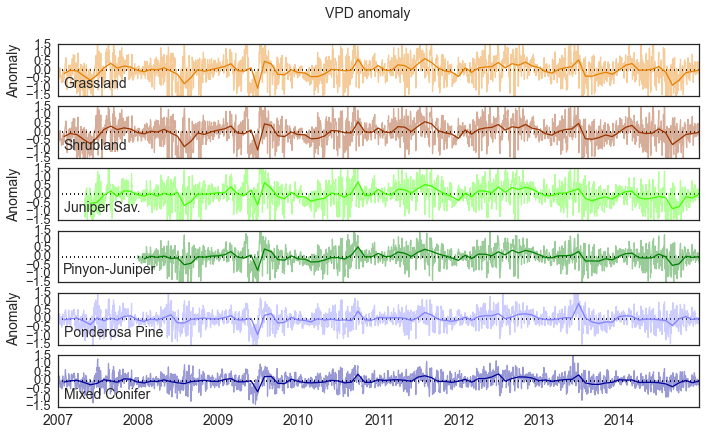

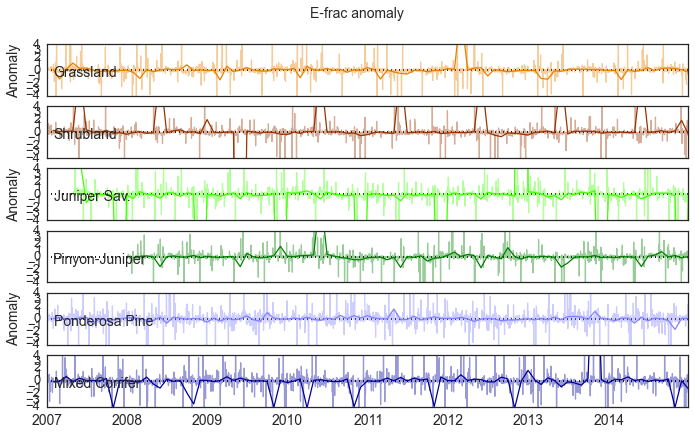

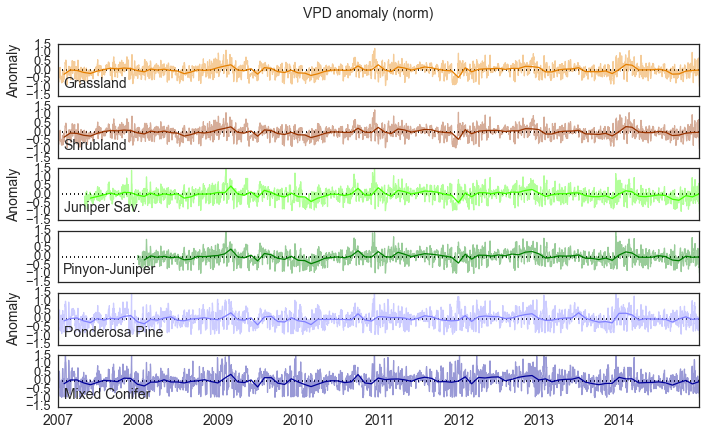

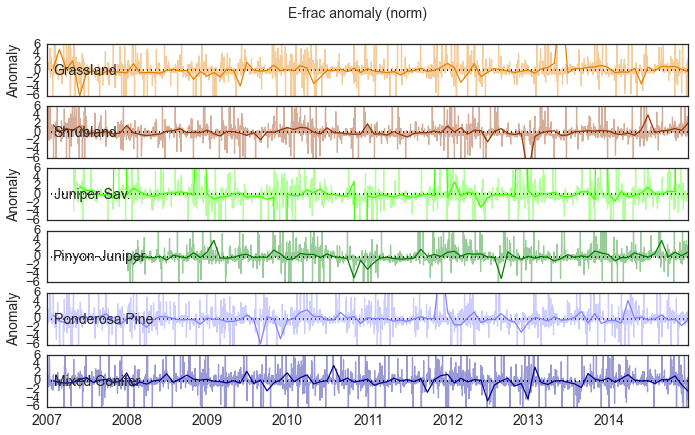

In [20]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

varlist = ['VPD_F','evap_frac', 'VPD_F','evap_frac']
ylabs = ['VPD anomaly', 'E-frac anomaly', 'VPD anomaly (norm)', 'E-frac anomaly (norm)']
ylims = [[-1.5, 1.5],[-4, 4],[-1.5, 1.5],[-6, 6]]

for i, anom in enumerate([vpd_anom, ef_anom, vpd_anom_n, ef_anom_n]):
    # Resample anomaly to monthly mean
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    plot_tseries2( anom, anom_m, -1,fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i], size=14)

## Plot anomaly and detected conditions

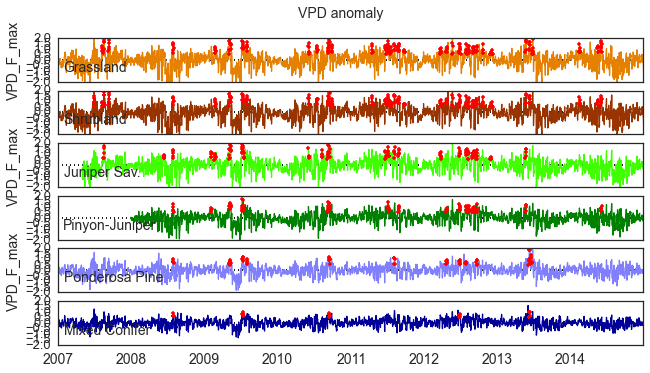

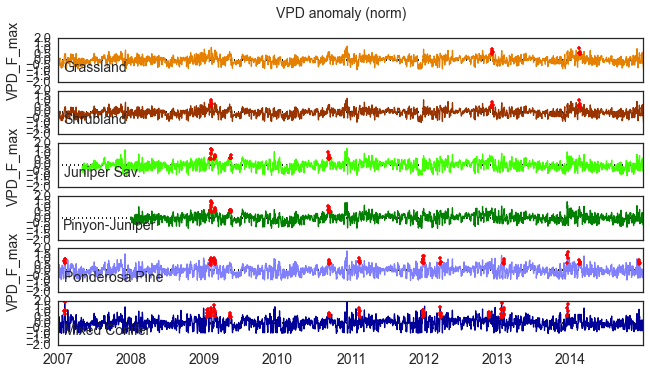

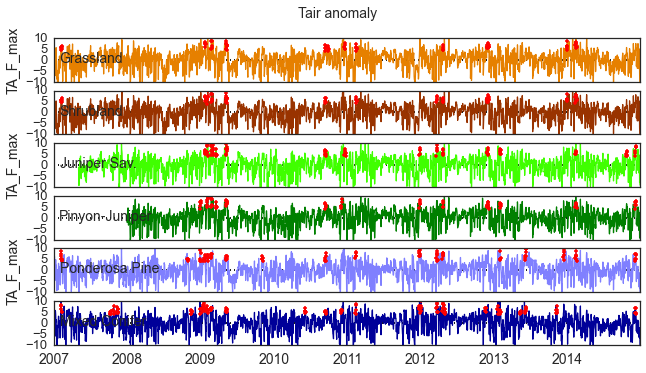

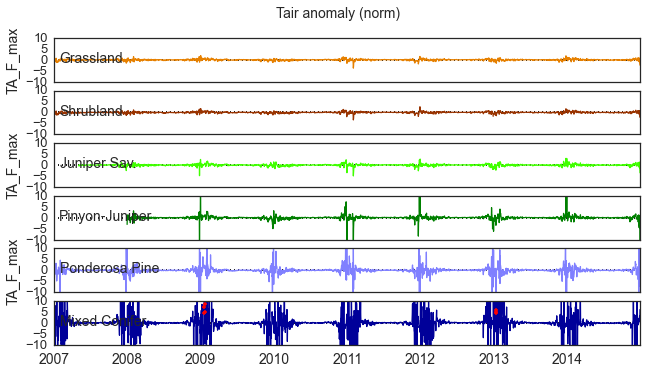

In [21]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]
#%matplotlib
varlist = ['VPD_F_max', 'VPD_F_max', 'TA_F_max', 'TA_F_max']
ylabs = ['VPD anomaly', 'VPD anomaly (norm)', 'Tair anomaly', 'Tair anomaly (norm)']
ylims = [[-2, 2],[-2, 2],[-10, 10],[-10, 10]]

vpd_anom_cond = {x: pd.Series(condition_duration_match( vpd_anom[x] > 0.5, 5 ), 
                         index=vpd_anom[x].index ) for x in vpd_anom.keys()};
vpd_anom_n_cond = {x: pd.Series(condition_duration_match( vpd_anom_n[x] > 0.5, 5 ), 
                         index=vpd_anom_n[x].index ) for x in vpd_anom_n.keys()};
pd.DataFrame(vpd_anom_cond).to_csv('processed_data/VPD_anom_dates.csv')
pd.DataFrame(vpd_anom_n_cond).to_csv('processed_data/VPD_anom_norm_dates.csv')

TA_anom_cond = {x: pd.Series(condition_duration_match( TA_anom[x] > 4, 5 ), 
                         index=TA_anom[x].index ) for x in TA_anom.keys()};
TA_anom_n_cond = {x: pd.Series(condition_duration_match( TA_anom_n[x] > 4, 5 ), 
                         index=TA_anom_n[x].index ) for x in TA_anom_n.keys()};
pd.DataFrame(TA_anom_cond).to_csv('processed_data/TA_anom_dates.csv')
pd.DataFrame(TA_anom_n_cond).to_csv('processed_data/TA_anom_norm_dates.csv')

anom_cond = [pd.DataFrame(vpd_anom_cond), pd.DataFrame(vpd_anom_n_cond),
             pd.DataFrame(TA_anom_cond), pd.DataFrame(TA_anom_n_cond)]
for i, anom in enumerate([vpd_anom, vpd_anom_n, TA_anom, TA_anom_n]):
    # Plot timeseries of VPD anomaly and highlight days that meet the conditions above
    fig = plt.figure(figsize=( 10.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
    ax = nmegplt.plot_tseries( anom, varlist[i], -1, fig, varlist[i], ylims=ylims[i])
    for j, site in enumerate(nmegplt.sites):
        series = anom[site].loc[anom_cond[i][site]]
        ax[j].plot( series.index, series.values, linestyle='None', marker='.', color='Red' )
        
    if i==0:
        fig.savefig('figures/labmeeting/VPD_anomaly.svg', dpi=150)
    plt.suptitle(ylabs[i], size=14)

In [5]:
# Show dates that meet the condition above (>= 0.5 vpd anomaly more than 5 days)
# This is for the normalized data
#for site in nmegplt.sites:
#    print(vpd_anom_cond[site].index[vpd_anom_cond[site]])

## Diurnal curves

In [22]:
import math
def get_diurnal_pattern( df, dates, get_inverse=False ):
    # Match days meeting condition to hourly timestamps
    match = pd.to_datetime(df.index.date).isin(dates)
    # Separate the condition from not-condition
    subset = df.loc[match,:]
    # Group by time of day
    mean_30min = subset.groupby(subset.index.time).mean()
    std_30min = subset.groupby(subset.index.time).std()
    std_30min['size'] = subset.groupby(subset.index.time).size()
    
    if get_inverse:
        subset_not = df.loc[~match,:]
        mean_30min_not = subset_not.groupby(subset_not.index.time).mean()
        std_30min_not = subset.groupby(subset.index.time).std()
        std_30min_not['size'] = subset.groupby(subset.index.time).size()
        return mean_30min, mean_30min_not, std_30min, std_30min_not
    else:
        return mean_30min, std_30min

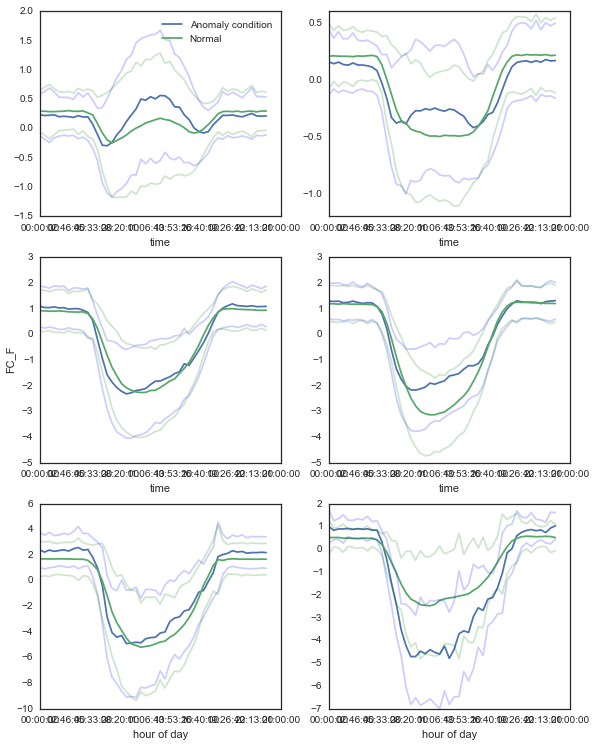

In [23]:
fig = plt.figure(figsize=( 9.5, 12.5 ), dpi=150, facecolor='w', edgecolor='k')
def plot_diurnal( variable ):
    for i, site in enumerate( sites ):
        dates = vpd_anom_cond[site].index[vpd_anom_cond[site]]
        mean_dat, mean_dat_not, std_30min, std_30min_not = get_diurnal_pattern( 
            hourly[ site ], dates, get_inverse=True )
        ax = plt.subplot( 3, 2, i+1 )
        plt.plot(mean_dat.index, mean_dat[variable])
        plt.plot(mean_dat_not.index, mean_dat_not[variable])
        #plt.plot(mean_dat.index, mean_dat[variable] + 
        #         (std_30min[variable] / math.sqrt(std_30min.size)), color='gray', alpha=.5)
        #plt.plot(mean_dat.index, mean_dat[variable] - 
        #         (std_30min[variable] / math.sqrt(std_30min.size)), color='gray', alpha=.5)
        plt.plot(mean_dat.index, mean_dat[variable] + 
                 std_30min[variable], color='blue', alpha=.2)
        plt.plot(mean_dat.index, mean_dat[variable] - 
                 std_30min[variable], color='blue', alpha=.2)
        plt.plot(mean_dat_not.index, mean_dat_not[variable] + 
                 std_30min_not[variable], color='green', alpha=.2)
        plt.plot(mean_dat_not.index, mean_dat_not[variable] - 
                 std_30min_not[variable], color='green', alpha=.2)
        if i==0:
            plt.legend(['Anomaly condition', 'Normal'])
        elif i==2:
            plt.ylabel(variable)
        elif i > 3:
            plt.xlabel('hour of day')
        


plot_diurnal('FC_F')
fig.savefig('figures/labmeeting/fc_diurnal.svg', dpi=150)

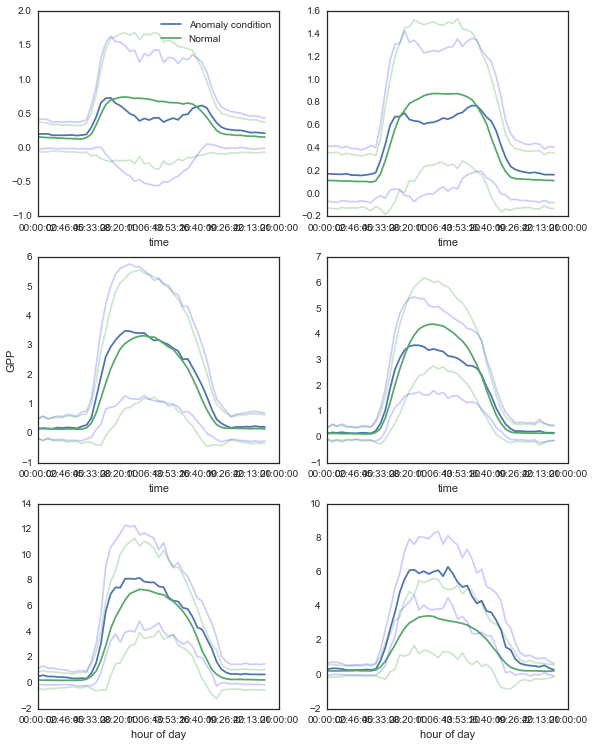

In [24]:
fig = plt.figure(figsize=( 9.5, 12.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_diurnal('GPP')
fig.savefig('figures/labmeeting/gpp_diurnal.svg', dpi=150)

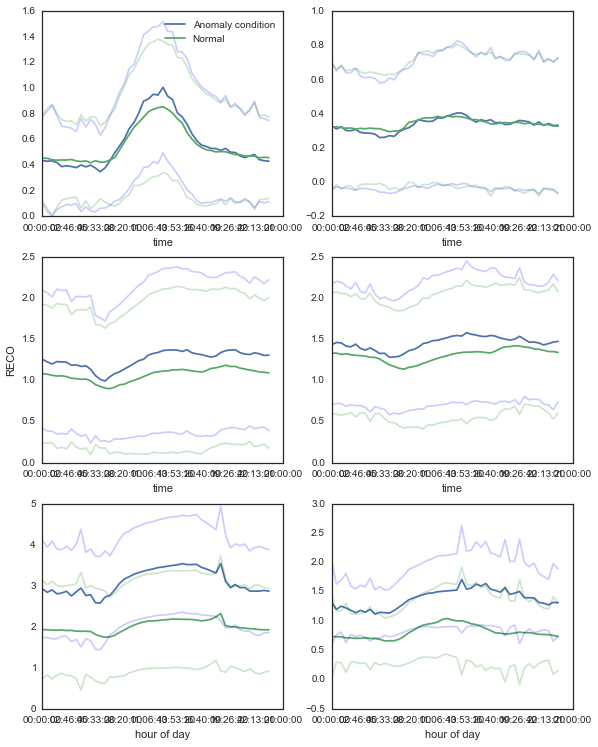

In [25]:
fig = plt.figure(figsize=( 9.5, 12.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_diurnal('RECO')
fig.savefig('figures/labmeeting/reco_diurnal.svg', dpi=150)